In [ ]:
import jax
import jax.numpy as np
from jax import random, grad, vmap, jit
from jax.nn import tanh
from jax.example_libraries import optimizers
import matplotlib.pyplot as plt
import itertools
from functools import partial
from tqdm import trange

# 为了可复现性，我们固定 JAX 的随机种子
key = random.PRNGKey(0)

In [ ]:
# The only change is removing static_argnums=(2,) from this decorator
@partial(jit)
def exact_nls_solution(t, x, params):
    """
    根据论文计算 N-分量 NLS 方程的单暗孤子精确解。
    """
    c = params['c']
    a = params['a']
    lambda1 = params['lambda1']
    mu1 = params['mu1']
    alpha = params['alpha']

    sigma = -1.0
    sum_c_sq = np.sum(c**2)

    # 对每个分量分别计算
    N_components = len(c)
    q_solution = np.zeros((N_components,) + np.shape(x), dtype=complex)

    for i in range(N_components):
        theta = a[i] * x - (0.5 * a[i]**2 - sigma * sum_c_sq) * t

        mu1_real = np.real(mu1)
        mu1_imag = np.imag(mu1)

        B = (mu1 - np.conj(mu1)) / (lambda1 + a[i] + mu1)
        Y1 = -mu1_imag * (x + (lambda1 + mu1_real) * t + alpha)

        q_solution = q_solution.at[i].set(c[i] * (1 - 0.5*B + 0.5*B * np.tanh(Y1)) * np.exp(1j * theta))

    return q_solution


def generate_data_points(params, t_domain, x_domain, N_ic, N_bc, N_res):
    """
    为单个初始条件生成训练数据点。
    """
    t_min, t_max = t_domain
    x_min, x_max = x_domain

    # 1. 初始条件 (IC) 数据

    x_ic = np.linspace(x_min, x_max, N_ic)
    t_ic = np.zeros_like(x_ic)  # 改回数组形式
    q_ic = vmap(lambda x: exact_nls_solution(0.0, x, params))(x_ic)

    # 2. 边界条件 (BC) 数据
    t_bc = np.linspace(t_min, t_max, N_bc)
    x_bc_min = x_min  # 标量
    x_bc_max = x_max  # 标量
    # 对每个 t 点计算
    q_bc_min = vmap(lambda t: exact_nls_solution(t, x_bc_min, params))(t_bc)
    q_bc_max = vmap(lambda t: exact_nls_solution(t, x_bc_max, params))(t_bc)

    # 3. 物理残差 (Collocation) 数据
    key_t, key_x = random.split(random.PRNGKey(42))
    t_res = random.uniform(key_t, shape=(N_res, 1), minval=t_min, maxval=t_max)
    x_res = random.uniform(key_x, shape=(N_res, 1), minval=x_min, maxval=x_max)

    data = {
        'IC': {'t': t_ic, 'x': x_ic, 'q': q_ic},
        'BC': {'t': t_bc, 'x_min': x_bc_min, 'x_max': x_bc_max, 'q_min': q_bc_min, 'q_max': q_bc_max},
        'RES': {'t': t_res.flatten(), 'x': x_res.flatten()}
    }
    return data

In [ ]:
# 单元格 3: DataGenerator 类
class DataGenerator:
    def __init__(self, u_data, y_data, q_data, batch_size=64):
        self.u_data = u_data
        self.y_data = y_data

        # 修复：将复数目标数据转换为拼接后的实数形式 [real, imag]
        if np.iscomplexobj(q_data):
            q_real = np.real(q_data)
            q_imag = np.imag(q_data)
            # 确保拼接维度正确
            self.q_data = np.concatenate([q_real, q_imag], axis=-1)
        else:
            self.q_data = q_data

        self.batch_size = batch_size
        self.num_samples = u_data.shape[0]
        self.key = random.PRNGKey(1234)

    def __iter__(self):
        return self

    def __next__(self):
        self.key, subkey = random.split(self.key)
        indices = random.choice(subkey, self.num_samples, (self.batch_size,), replace=False)

        inputs = (self.u_data[indices, :], self.y_data[indices, :])
        outputs = self.q_data[indices, :]

        return {'inputs': inputs, 'outputs': outputs}

In [ ]:
# 单元格 4 (最终、完整修正版): ComplexDeepONet 类
@jit
def fourier_encoding(x, B):
    x_proj = np.dot(x, B)
    return np.hstack([np.sin(x_proj), np.cos(x_proj)])

class ComplexDeepONet:
    def __init__(self, branch_layers, trunk_layers, N_components):
        self.branch_layers = branch_layers
        self.trunk_layers = trunk_layers
        self.N_components = N_components

        # 初始化网络
        self.branch_init, self.branch_apply = self.MLP(branch_layers, activation=tanh)
        self.trunk_init, self.trunk_apply = self.FF_MLP(trunk_layers, activation=tanh)

        branch_key, trunk_key = random.split(random.PRNGKey(1234), 2)
        branch_params = self.branch_init(branch_key)
        trunk_params = self.trunk_init(trunk_key)
        self.params = (branch_params, trunk_params)

        # 设置优化器
        self.opt_init, self.opt_update, self.get_params = optimizers.adam(
            optimizers.exponential_decay(1e-3, decay_steps=2000, decay_rate=0.9)
        )
        self.opt_state = self.opt_init(self.params)
        self.itercount = itertools.count()

        # JIT 编译核心函数
        self._loss = jit(self._calculate_total_loss)
        self._step = jit(self._update_step)

        # 日志
        self.loss_log = []
        self.loss_ics_log = []
        self.loss_bcs_log = []
        self.loss_res_log = []

    def MLP(self, layers, activation=tanh):
        def init(rng_key):
            def init_layer(key, d_in, d_out):
                stddev = np.sqrt(2 / (d_in + d_out))
                W = random.truncated_normal(key, -2, 2, (d_in, d_out)) * stddev
                b = np.zeros(d_out)
                return W, b
            key, *keys = random.split(rng_key, len(layers))
            params = list(map(init_layer, keys, layers[:-1], layers[1:]))
            return params
        def apply(params, inputs):
            for W, b in params[:-1]:
                outputs = np.dot(inputs, W) + b
                inputs = activation(outputs)
            W, b = params[-1]
            outputs = np.dot(inputs, W) + b
            return outputs
        return init, apply

    def FF_MLP(self, layers, activation=tanh, B_scale=10.0):
        key = random.PRNGKey(0)
        input_dim = layers[0]
        fourier_dim = layers[1] // 2
        B = random.normal(key, (input_dim, fourier_dim)) * B_scale

        ff_layers = [layers[1]] + layers[2:]
        init_mlp, apply_mlp = self.MLP(ff_layers, activation)

        def init(rng_key):
            return init_mlp(rng_key)

        def apply(params, inputs):
            encoded_inputs = fourier_encoding(inputs, B)
            return apply_mlp(params, encoded_inputs)

        return init, apply

    def operator_net(self, params, u_initial, y_coords):
        branch_params, trunk_params = params
        branch_output = self.branch_apply(branch_params, u_initial)
        trunk_output = self.trunk_apply(trunk_params, y_coords)

        p = self.trunk_layers[-1]
        batch_size = u_initial.shape[0]

        expected_branch_size = self.N_components * 2 * p
        if branch_output.shape[-1] != expected_branch_size:
            raise ValueError(f"Branch output dimension mismatch: expected {expected_branch_size}, got {branch_output.shape[-1]}")

        branch_reshaped = branch_output.reshape(batch_size, self.N_components * 2, p)
        trunk_expanded = trunk_output[:, None, :]

        final_output = np.sum(branch_reshaped * trunk_expanded, axis=2)

        return final_output

    def residual_net(self, params, u_initial, t, x):
        def q_func(t, x):
            output = self.operator_net(params, u_initial[None, :], np.array([[t, x]]))[0]
            real_part = output[:self.N_components]
            imag_part = output[self.N_components:]
            return real_part + 1j * imag_part

        q_t_complex = jax.jacfwd(q_func, argnums=0)(t, x)
        q_xx_complex = jax.jacfwd(jax.jacfwd(q_func, argnums=1), argnums=1)(t, x)
        q_val_complex = q_func(t, x)

        # --- 最终修正：实现 qq†Λ1q ---
        Lambda1 = -np.eye(self.N_components)
        q_val_col = q_val_complex[:, None]
        q_dagger = np.conj(q_val_col).T
        qq_dagger_matrix = np.dot(q_val_col, q_dagger)
        term_matrix = np.dot(qq_dagger_matrix, Lambda1)
        nonlinear_term_col = np.dot(term_matrix, q_val_col)
        nonlinear_term = nonlinear_term_col.flatten()
        # --- 修正结束 ---

        residual = 1j * q_t_complex + 0.5 * q_xx_complex + nonlinear_term
        return np.sum(np.abs(residual)**2)

    def loss_ics(self, params, ic_batch):
        inputs, outputs = ic_batch['inputs'], ic_batch['outputs']
        q_pred = self.operator_net(params, *inputs)
        return np.mean((outputs - q_pred)**2)

    def loss_bcs(self, params, bc_batch):
        inputs, outputs = bc_batch['inputs'], bc_batch['outputs']
        q_pred = self.operator_net(params, *inputs)
        return np.mean((outputs - q_pred)**2)

    def loss_res(self, params, res_batch):
        inputs, _ = res_batch['inputs'], res_batch['outputs']
        res_pred = vmap(lambda u, y: self.residual_net(params, u, y[0], y[1]))(*inputs)
        return np.mean(res_pred)

    def _calculate_total_loss(self, params, ic_batch, bc_batch, res_batch):
        loss_i = self.loss_ics(params, ic_batch)
        loss_b = self.loss_bcs(params, bc_batch)
        loss_r = self.loss_res(params, res_batch)
        total_loss = 10.0 * loss_i + 10.0 * loss_b + loss_r
        return total_loss

    @partial(jit, static_argnums=(0,))
    def _update_step(self, i, opt_state, ic_batch, bc_batch, res_batch):
        params = self.get_params(opt_state)
        g = grad(self._calculate_total_loss)(params, ic_batch, bc_batch, res_batch)
        return self.opt_update(i, g, opt_state)

    def train(self, ic_dataset, bc_dataset, res_dataset, nIter=10000):
        ic_data_iter = iter(ic_dataset)
        bc_data_iter = iter(bc_dataset)
        res_data_iter = iter(res_dataset)
        pbar = trange(nIter)
        for it in pbar:
            ic_batch = next(ic_data_iter)
            bc_batch = next(bc_data_iter)
            res_batch = next(res_data_iter)
            self.opt_state = self._update_step(next(self.itercount), self.opt_state, ic_batch, bc_batch, res_batch)
            if it % 100 == 0:
                self.params = self.get_params(self.opt_state)
                loss_val = self._loss(self.params, ic_batch, bc_batch, res_batch)
                loss_i_val = self.loss_ics(self.params, ic_batch)
                loss_b_val = self.loss_bcs(self.params, bc_batch)
                loss_r_val = self.loss_res(self.params, res_batch)
                self.loss_log.append(loss_val)
                self.loss_ics_log.append(loss_i_val)
                self.loss_bcs_log.append(loss_b_val)
                self.loss_res_log.append(loss_r_val)
                pbar.set_postfix({'Total Loss': f'{loss_val:.2e}', 'IC': f'{loss_i_val:.2e}', 'BC': f'{loss_b_val:.2e}', 'Res': f'{loss_r_val:.2e}'})

    @partial(jit, static_argnums=(0,))
    def predict_q(self, params, u_initial_batch, y_coords_batch):
        output = self.operator_net(params, u_initial_batch, y_coords_batch)
        real_part = output[:, :self.N_components]
        imag_part = output[:, self.N_components:]
        return real_part + 1j * imag_part

In [ ]:
# 单元格 5 (动态参数生成版): 数据准备与网络定义

N_components = 3

# 动态参数生成器
class DynamicParamGenerator:
    def __init__(self, N_components, seed=42):
        self.N_components = N_components
        self.key = random.PRNGKey(seed)

    def generate_random_params(self):
        """每次调用生成一组新的随机参数"""
        self.key, *subkeys = random.split(self.key, 5)

        # 随机生成参数范围
        c_params = random.uniform(subkeys[0], (self.N_components,), minval=0.5, maxval=2.5)
        a_params = random.uniform(subkeys[1], (self.N_components,), minval=-0.3, maxval=0.3)
        mu_imag = random.uniform(subkeys[2], (), minval=1.0, maxval=3.0)
        alpha_val = random.uniform(subkeys[3], (), minval=-1.0, maxval=1.0)

        return {
            'c': c_params,
            'a': a_params,
            'lambda1': 0.0,
            'mu1': mu_imag * 1j,
            'alpha': alpha_val
        }

# 动态数据生成器
class DynamicDataGenerator:
    def __init__(self, param_generator, t_domain, x_domain, N_ic, N_bc, N_res, batch_size=64):
        self.param_generator = param_generator
        self.t_domain = t_domain
        self.x_domain = x_domain
        self.N_ic = N_ic
        self.N_bc = N_bc
        self.N_res = N_res
        self.batch_size = batch_size
        self.N_components = param_generator.N_components

    def generate_batch_data(self, data_type):
        """为每个批次生成新的参数和对应数据"""
        # 生成新参数
        params = self.param_generator.generate_random_params()

        # 生成对应的数据点
        data_points = generate_data_points(params, self.t_domain, self.x_domain,
                                         self.N_ic, self.N_bc, self.N_res)

        # 处理初始条件
        u_initial_real = np.real(data_points['IC']['q']).flatten()
        u_initial_imag = np.imag(data_points['IC']['q']).flatten()
        u_initial = np.hstack([u_initial_real, u_initial_imag])

        if data_type == 'IC':
            # IC数据
            ic_u = np.tile(u_initial, (self.batch_size, 1))
            # 随机选择batch_size个点
            indices = random.choice(random.PRNGKey(0), self.N_ic, (self.batch_size,), replace=False)
            ic_y = np.hstack([data_points['IC']['t'][indices, None],
                             data_points['IC']['x'][indices, None]])
            ic_q_complex = data_points['IC']['q'][indices]
            ic_q_real = np.real(ic_q_complex)
            ic_q_imag = np.imag(ic_q_complex)
            ic_q = np.hstack([ic_q_real, ic_q_imag])

            return {'inputs': (ic_u, ic_y), 'outputs': ic_q}

        elif data_type == 'BC':
            # BC数据
            bc_u = np.tile(u_initial, (self.batch_size, 1))
            # 随机选择时间点和边界
            t_indices = random.choice(random.PRNGKey(1), self.N_bc, (self.batch_size//2,), replace=False)
            bc_t = np.hstack([data_points['BC']['t'][t_indices],
                             data_points['BC']['t'][t_indices]])[:, None]
            bc_x = np.hstack([
                np.full(self.batch_size//2, data_points['BC']['x_min']),
                np.full(self.batch_size//2, data_points['BC']['x_max'])
            ])[:, None]
            bc_y = np.hstack([bc_t, bc_x])

            bc_q_complex = np.vstack([data_points['BC']['q_min'][t_indices],
                                     data_points['BC']['q_max'][t_indices]])
            bc_q_real = np.real(bc_q_complex)
            bc_q_imag = np.imag(bc_q_complex)
            bc_q = np.hstack([bc_q_real, bc_q_imag])

            return {'inputs': (bc_u, bc_y), 'outputs': bc_q}

        elif data_type == 'RES':
            # RES数据
            res_u = np.tile(u_initial, (self.batch_size, 1))
            # 随机选择配置点
            indices = random.choice(random.PRNGKey(2), self.N_res, (self.batch_size,), replace=False)
            res_y = np.hstack([data_points['RES']['t'][indices, None],
                              data_points['RES']['x'][indices, None]])
            res_q = np.zeros((self.batch_size, self.N_components * 2))

            return {'inputs': (res_u, res_y), 'outputs': res_q}

# 动态数据迭代器
class DynamicDataIterator:
    def __init__(self, dynamic_generator, data_type):
        self.dynamic_generator = dynamic_generator
        self.data_type = data_type

    def __iter__(self):
        return self

    def __next__(self):
        return self.dynamic_generator.generate_batch_data(self.data_type)

# 域定义
t_domain = [0.0, 1.0]
x_domain = [-5.0, 5.0]

# 数据点数量
N_ic_train = 512
N_bc_train = 256
N_res_train = 10000

# 网络结构参数
branch_input_dim = N_ic_train * N_components * 2
p = 100
branch_output_dim = N_components * 2 * p
branch_layers = [branch_input_dim, 256, 256, branch_output_dim]
trunk_layers = [2, 128, 128, 128, p]

# 创建动态参数生成器
param_generator = DynamicParamGenerator(N_components)

# 创建动态数据生成器
dynamic_data_gen = DynamicDataGenerator(param_generator, t_domain, x_domain,
                                       N_ic_train, N_bc_train, N_res_train, batch_size=64)

# 创建动态数据迭代器
ic_dataset = DynamicDataIterator(dynamic_data_gen, 'IC')
bc_dataset = DynamicDataIterator(dynamic_data_gen, 'BC')
res_dataset = DynamicDataIterator(dynamic_data_gen, 'RES')

print(f"动态参数训练设置:")
print(f"N_components: {N_components}")
print(f"Branch网络层级: {branch_layers}")
print(f"Trunk网络层级: {trunk_layers}")
print(f"每个训练步骤都会生成新的随机参数!")

# 验证动态数据生成
print("\n=== 动态数据验证 ===")
ic_batch_test = next(iter(ic_dataset))
bc_batch_test = next(iter(bc_dataset))
res_batch_test = next(iter(res_dataset))

print(f"IC batch - inputs: {[x.shape for x in ic_batch_test['inputs']]}, outputs: {ic_batch_test['outputs'].shape}")
print(f"BC batch - inputs: {[x.shape for x in bc_batch_test['inputs']]}, outputs: {bc_batch_test['outputs'].shape}")
print(f"RES batch - inputs: {[x.shape for x in res_batch_test['inputs']]}, outputs: {res_batch_test['outputs'].shape}")

# 验证参数确实在变化
print("\n=== 参数变化验证 ===")
for i in range(3):
    params = param_generator.generate_random_params()
    print(f"参数组 {i+1}: c={params['c'][:2]}, mu1={params['mu1']}")

动态参数训练设置:
N_components: 3
Branch网络层级: [3072, 256, 256, 600]
Trunk网络层级: [2, 128, 128, 128, 100]
每个训练步骤都会生成新的随机参数!

=== 动态数据验证 ===
IC batch - inputs: [(64, 3072), (64, 2)], outputs: (64, 6)
BC batch - inputs: [(64, 3072), (64, 2)], outputs: (64, 6)
RES batch - inputs: [(64, 3072), (64, 2)], outputs: (64, 6)

=== 参数变化验证 ===
参数组 1: c=[1.9992998 1.1108007], mu1=2.837601661682129j
参数组 2: c=[2.2768438 0.9240906], mu1=1.9907078742980957j
参数组 3: c=[2.0856698  0.79769087], mu1=1.3697113990783691j


In [ ]:
# 检查数据集结构
print("IC dataset structure:")
ic_batch_debug = next(iter(ic_dataset))
print(f"IC batch type: {type(ic_batch_debug)}")
print(f"IC batch keys/length: {ic_batch_debug.keys() if hasattr(ic_batch_debug, 'keys') else len(ic_batch_debug)}")

print("\nBC dataset structure:")
bc_batch_debug = next(iter(bc_dataset))
print(f"BC batch type: {type(bc_batch_debug)}")
print(f"BC batch keys/length: {bc_batch_debug.keys() if hasattr(bc_batch_debug, 'keys') else len(bc_batch_debug)}")

print("\nRES dataset structure:")
res_batch_debug = next(iter(res_dataset))
print(f"RES batch type: {type(res_batch_debug)}")
print(f"RES batch keys/length: {res_batch_debug.keys() if hasattr(res_batch_debug, 'keys') else len(res_batch_debug)}")

# 检查具体的数据形状
print("IC dataset shapes:")
print(f"IC inputs type: {type(ic_batch_debug['inputs'])}")
print(f"IC inputs length: {len(ic_batch_debug['inputs'])}")
for i, inp in enumerate(ic_batch_debug['inputs']):
    print(f"IC inputs[{i}] shape: {inp.shape}")
print(f"IC outputs shape: {ic_batch_debug['outputs'].shape}")

print("\nBC dataset shapes:")
print(f"BC inputs type: {type(bc_batch_debug['inputs'])}")
print(f"BC inputs length: {len(bc_batch_debug['inputs'])}")
for i, inp in enumerate(bc_batch_debug['inputs']):
    print(f"BC inputs[{i}] shape: {inp.shape}")
print(f"BC outputs shape: {bc_batch_debug['outputs'].shape}")

print("\nRES dataset shapes:")
print(f"RES inputs type: {type(res_batch_debug['inputs'])}")
print(f"RES inputs length: {len(res_batch_debug['inputs'])}")
for i, inp in enumerate(res_batch_debug['inputs']):
    print(f"RES inputs[{i}] shape: {inp.shape}")
print(f"RES outputs shape: {res_batch_debug['outputs'].shape}")



IC dataset structure:
IC batch type: <class 'dict'>
IC batch keys/length: dict_keys(['inputs', 'outputs'])

BC dataset structure:
BC batch type: <class 'dict'>
BC batch keys/length: dict_keys(['inputs', 'outputs'])

RES dataset structure:
RES batch type: <class 'dict'>
RES batch keys/length: dict_keys(['inputs', 'outputs'])
IC dataset shapes:
IC inputs type: <class 'tuple'>
IC inputs length: 2
IC inputs[0] shape: (64, 3072)
IC inputs[1] shape: (64, 2)
IC outputs shape: (64, 6)

BC dataset shapes:
BC inputs type: <class 'tuple'>
BC inputs length: 2
BC inputs[0] shape: (64, 3072)
BC inputs[1] shape: (64, 2)
BC outputs shape: (64, 6)

RES dataset shapes:
RES inputs type: <class 'tuple'>
RES inputs length: 2
RES inputs[0] shape: (64, 3072)
RES inputs[1] shape: (64, 2)
RES outputs shape: (64, 6)


In [ ]:
import pickle
import os

model = ComplexDeepONet(branch_layers, trunk_layers, N_components)

# 1. 从数据加载器中取一个批次用于调试
ic_batch_debug = next(iter(ic_dataset))
bc_batch_debug = next(iter(bc_dataset))
res_batch_debug = next(iter(res_dataset))

params_debug = model.get_params(model.opt_state)


print("开始训练...")
# 减少迭代次数以便快速演示
model.train(ic_dataset, bc_dataset, res_dataset, nIter=200000)
print("训练完成。")

# 保存模型参数
params_save_path = "model_params1.pkl"
with open(params_save_path, 'wb') as f:
    pickle.dump(model.params, f)
print(f"模型参数已保存到: {params_save_path}")

开始训练...


  2%|▏         | 4382/200000 [01:01<46:02, 70.82it/s, Total Loss=1.54e+01, IC=4.48e-01, BC=8.98e-01, Res=1.90e+00] 


KeyboardInterrupt: 

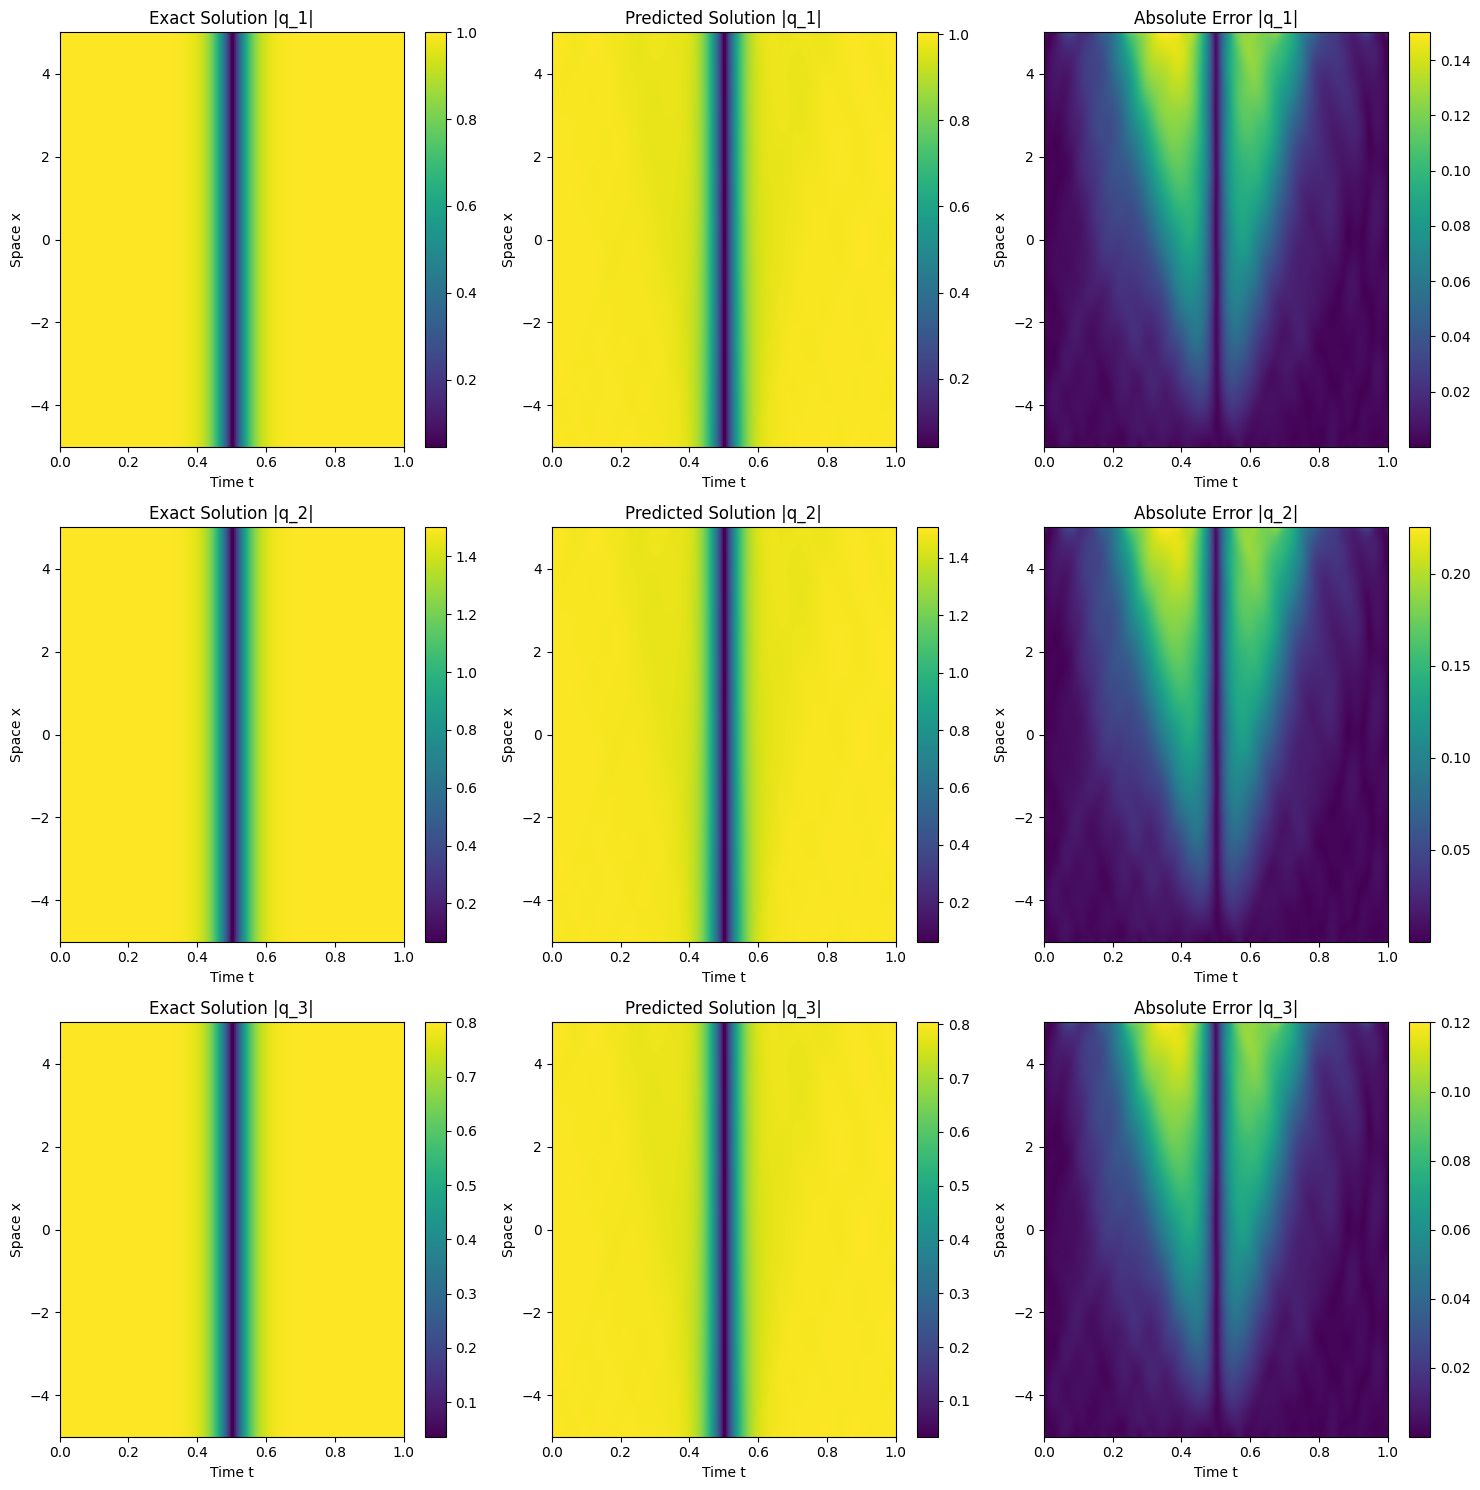

In [ ]:
# --- 可视化 ---
trained_params = model.get_params(model.opt_state)

# 创建一个网格用于预测和绘图
T, X = np.meshgrid(np.linspace(t_domain[0], t_domain[1], 100),
                   np.linspace(x_domain[0], x_domain[1], 200))

y_coords_test = np.hstack([T.flatten()[:, None], X.flatten()[:, None]])
u_initial_test = np.tile(u_initial_train, (y_coords_test.shape[0], 1))

# 预测
q_pred = model.predict_q(trained_params, u_initial_test, y_coords_test)
q_pred_grid = q_pred.reshape(T.shape[0], T.shape[1], N_components)

# 计算精确解
q_exact_flat = vmap(exact_nls_solution, (0, 0, None))(y_coords_test[:, 0], y_coords_test[:, 1], soliton_params)
q_exact_grid = q_exact_flat.reshape(T.shape[0], T.shape[1], N_components)

# 绘图
fig, axes = plt.subplots(N_components, 3, figsize=(15, 5 * N_components), dpi=100)
for i in range(N_components):
    ax_row = axes if N_components == 1 else axes[i]

    im1 = ax_row[0].imshow(np.abs(q_exact_grid[:, :, i]).T,
                            extent=[t_domain[0], t_domain[1], x_domain[0], x_domain[1]],
                            origin='lower', aspect='auto', cmap='viridis')
    ax_row[0].set_title(f'Exact Solution |q_{i+1}|')
    fig.colorbar(im1, ax=ax_row[0])

    im2 = ax_row[1].imshow(np.abs(q_pred_grid[:, :, i]).T,
                            extent=[t_domain[0], t_domain[1], x_domain[0], x_domain[1]],
                            origin='lower', aspect='auto', cmap='viridis')
    ax_row[1].set_title(f'Predicted Solution |q_{i+1}|')
    fig.colorbar(im2, ax=ax_row[1])

    im3 = ax_row[2].imshow(np.abs(q_exact_grid[:, :, i] - q_pred_grid[:, :, i]).T,
                            extent=[t_domain[0], t_domain[1], x_domain[0], x_domain[1]],
                            origin='lower', aspect='auto', cmap='viridis')
    ax_row[2].set_title(f'Absolute Error |q_{i+1}|')
    fig.colorbar(im3, ax=ax_row[2])

    for ax in ax_row:
        ax.set_xlabel('Time t')
        ax.set_ylabel('Space x')

plt.tight_layout()
plt.show()

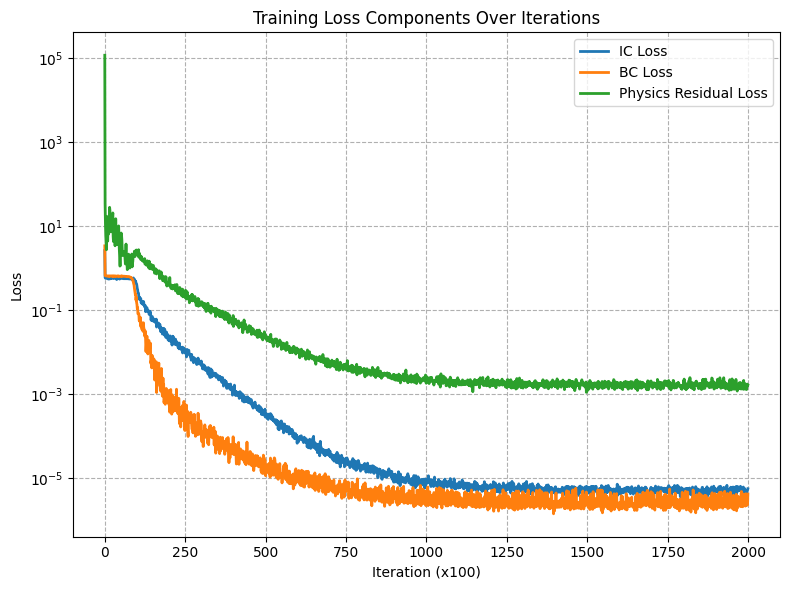

In [ ]:
# --- Visualizing Training Loss ---

plt.figure(figsize=(8, 6))
plt.plot(model.loss_ics_log, label='IC Loss', lw=2)
plt.plot(model.loss_bcs_log, label='BC Loss', lw=2)
plt.plot(model.loss_res_log, label='Physics Residual Loss', lw=2)

plt.xlabel('Iteration (x100)')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Training Loss Components Over Iterations')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.tight_layout()
plt.show()

--- 正在使用训练时的参数进行评估 ---
q_exact_complex shape: (20000, 3)
q_pred_complex shape: (20000, 3)
Relative L2 error (solution): 5.358e-02


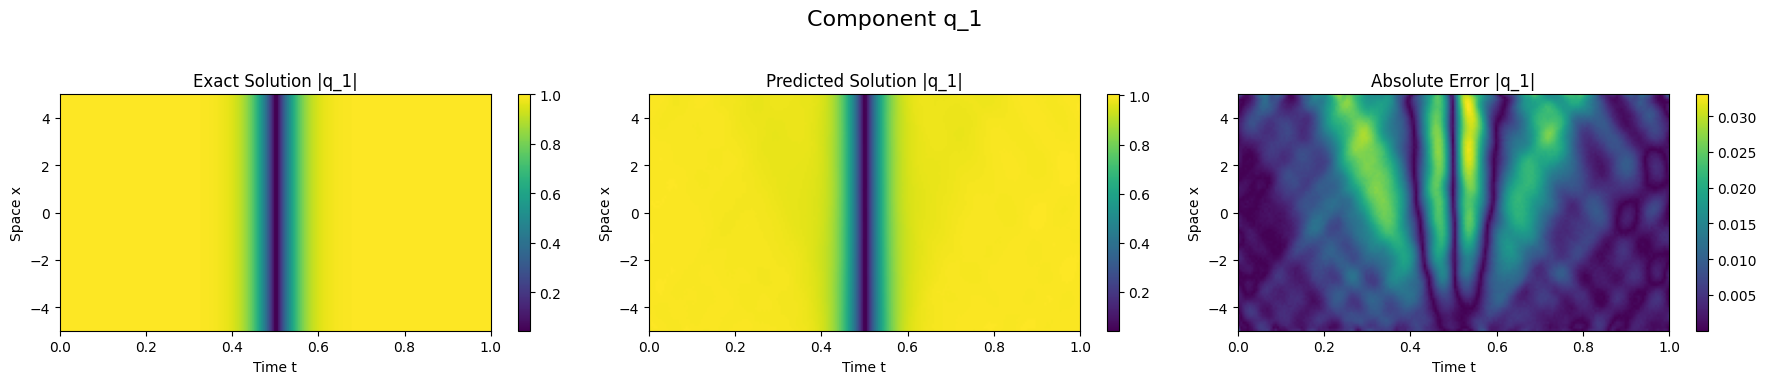

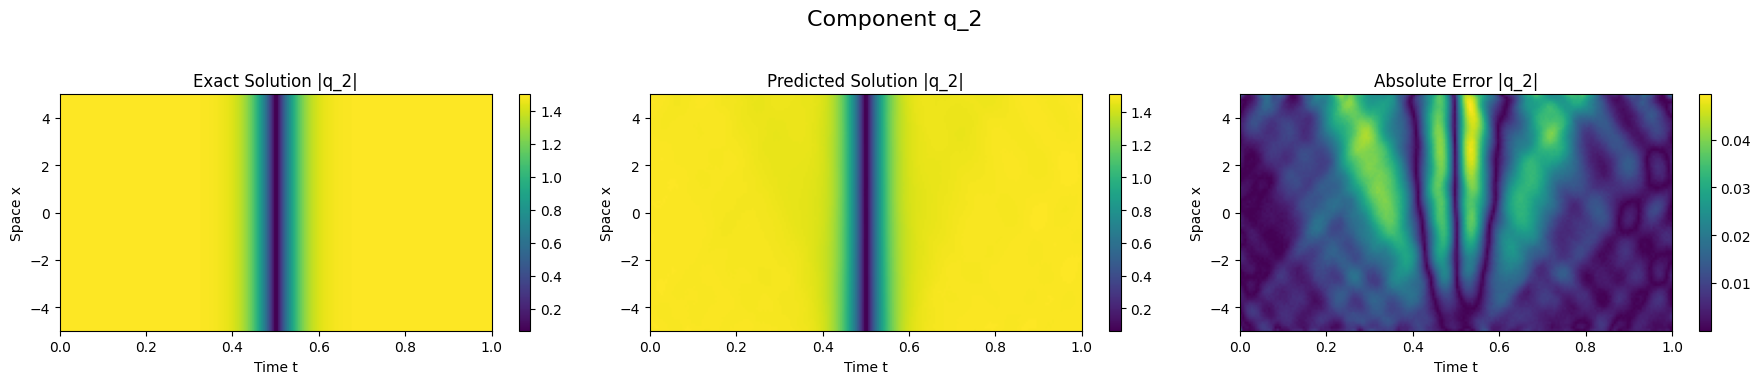

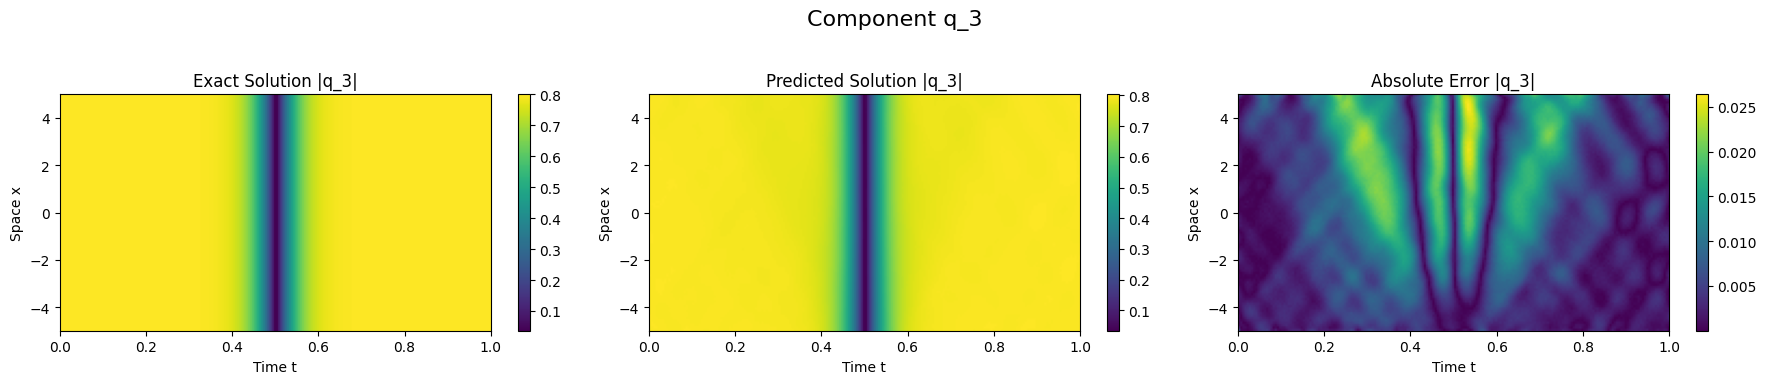

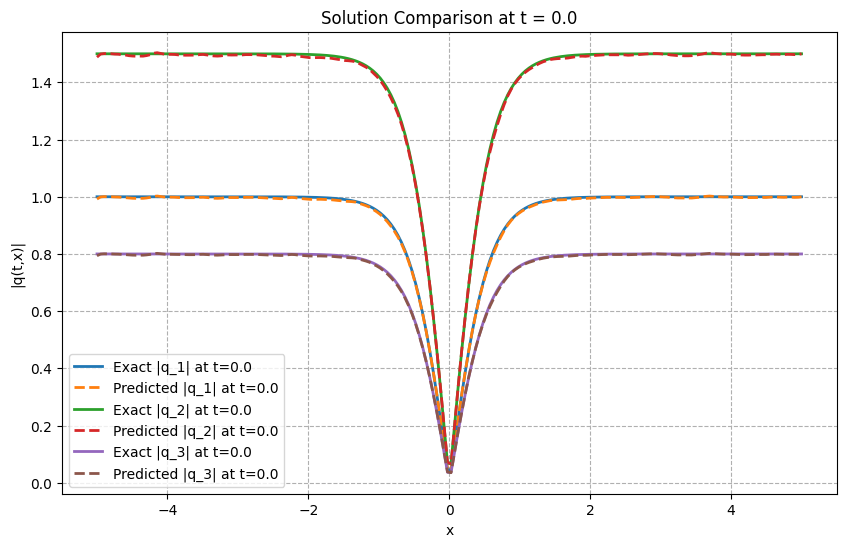

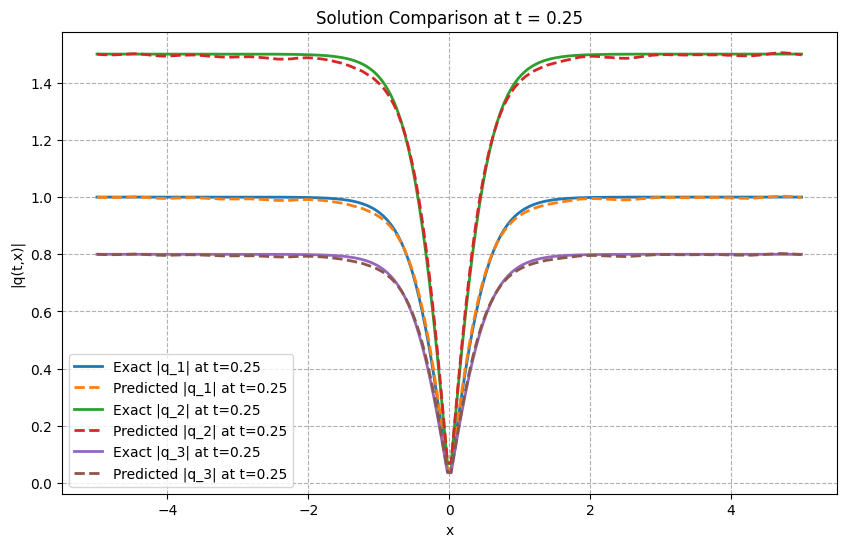

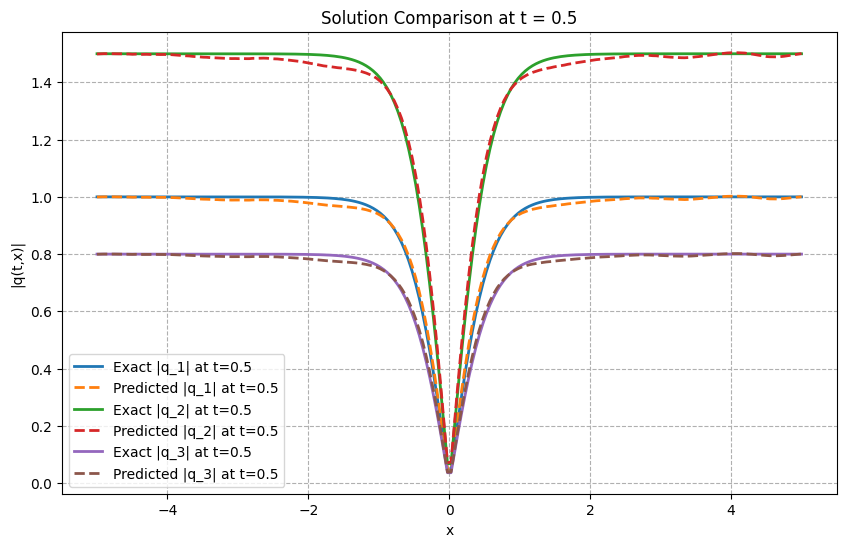

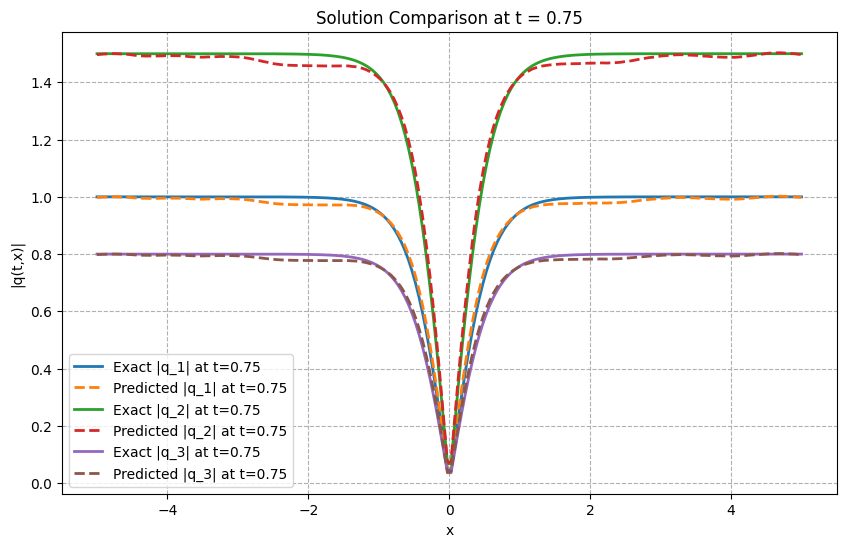

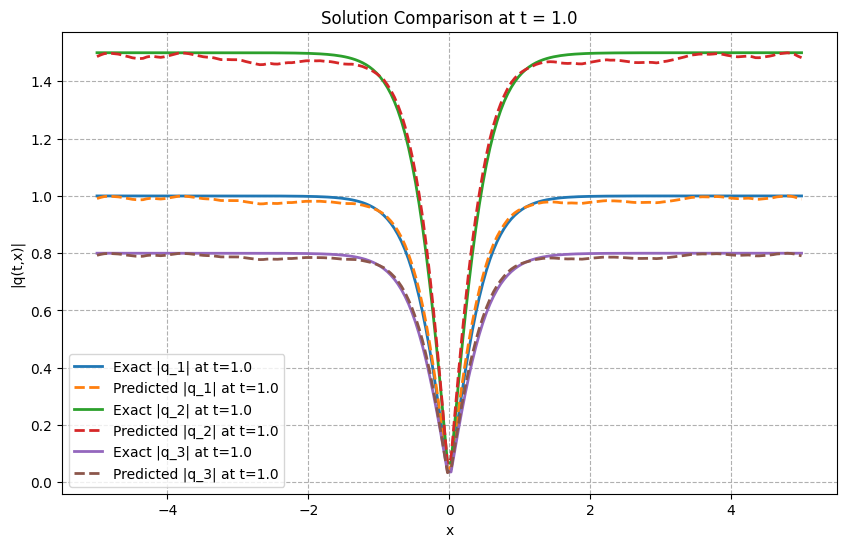

In [ ]:
# --- 最终修正的测试与可视化代码 (包含多个时间切片图) ---

# 1. 使用与训练时完全相同的参数来生成测试数据和精确解
print("--- 正在使用训练时的参数进行评估 ---")
test_params = {
    'c': np.array([1.0, 1.5,0.8]),
    'a': np.array([0.0, 0.0,0.0]),
    'lambda1': 0.0,
    'mu1': 1.8027756j,
    'alpha': 0.0
}

# 准备用于预测的网格坐标
T, X = np.meshgrid(np.linspace(t_domain[0], t_domain[1], 100),
                   np.linspace(x_domain[0], x_domain[1], 200))
y_coords_test = np.hstack([T.flatten()[:, None], X.flatten()[:, None]])

# 准备用于预测的初始条件 (u_initial_train 来自于训练单元格)
u_initial_test_batch = np.tile(u_initial_train, (y_coords_test.shape[0], 1))

# --- 模型预测 ---
q_pred_complex = model.predict_q(trained_params, u_initial_test_batch, y_coords_test)

# --- 计算对应的精确解 ---
q_exact_complex = vmap(lambda t, x: exact_nls_solution(t, x, test_params))(y_coords_test[:, 0], y_coords_test[:, 1])

# --- 打印形状以供验证 ---
print(f"q_exact_complex shape: {q_exact_complex.shape}")
print(f"q_pred_complex shape: {q_pred_complex.shape}")


# --- 正确计算相对L2误差 ---
error_q = np.linalg.norm(q_exact_complex - q_pred_complex, 'fro') / np.linalg.norm(q_exact_complex, 'fro')
print(f"Relative L2 error (solution): {error_q:.3e}")

# --- 重塑数据以便绘图 ---
q_exact_grid = q_exact_complex.reshape(X.shape[0], X.shape[1], N_components)
q_pred_grid = q_pred_complex.reshape(X.shape[0], X.shape[1], N_components)


# --- 可视化 ---
# 绘制每个分量的热图
for i in range(N_components):
    fig, axes = plt.subplots(1, 3, figsize=(18, 4))
    fig.suptitle(f'Component q_{i+1}', fontsize=16)

    # 精确解幅值
    im1 = axes[0].imshow(np.abs(q_exact_grid[:, :, i]).T,
                            extent=[t_domain[0], t_domain[1], x_domain[0], x_domain[1]],
                            origin='lower', aspect='auto', cmap='viridis')
    axes[0].set_title(f'Exact Solution |q_{i+1}|')
    fig.colorbar(im1, ax=axes[0])

    # 预测解幅值
    im2 = axes[1].imshow(np.abs(q_pred_grid[:, :, i]).T,
                            extent=[t_domain[0], t_domain[1], x_domain[0], x_domain[1]],
                            origin='lower', aspect='auto', cmap='viridis')
    axes[1].set_title(f'Predicted Solution |q_{i+1}|')
    fig.colorbar(im2, ax=axes[1])

    # 绝对误差
    im3 = axes[2].imshow(np.abs(np.abs(q_exact_grid[:, :, i]) - np.abs(q_pred_grid[:, :, i])).T,
                            extent=[t_domain[0], t_domain[1], x_domain[0], x_domain[1]],
                            origin='lower', aspect='auto', cmap='viridis')
    axes[2].set_title(f'Absolute Error |q_{i+1}|')
    fig.colorbar(im3, ax=axes[2])

    for ax in axes:
        ax.set_xlabel('Time t')
        ax.set_ylabel('Space x')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# --- 新增：循环绘制多个时间点的切面对比图 ---
time_slices_to_plot = [0.0, 0.25,0.5,0.75, 1.0]

for t_slice in time_slices_to_plot:
    t_index = np.argmin(np.abs(T[0, :] - t_slice))

    plt.figure(figsize=(10, 6))
    for i in range(N_components):
        plt.plot(X[:, t_index], np.abs(q_exact_grid[:, t_index, i]),
                 label=f'Exact |q_{i+1}| at t={t_slice}', lw=2)
        plt.plot(X[:, t_index], np.abs(q_pred_grid[:, t_index, i]), '--',
                 label=f'Predicted |q_{i+1}| at t={t_slice}', lw=2)

    plt.xlabel('x')
    plt.ylabel('|q(t,x)|')
    plt.title(f'Solution Comparison at t = {t_slice}')
    plt.legend()
    plt.grid(True, linestyle='--')
    plt.show()